In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv("amazon_reviews.csv", sep=",")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating
0,0,NaN,4,No issues.,7/23/2014,138,0,0,0,0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",10/25/2013,409,0,0,0,0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,12/23/2012,715,0,0,0,0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,11/21/2013,382,0,0,0,0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",7/13/2013,513,0,0,0,0,0.0


In [3]:
columns_to_drop = ['Unnamed: 0','reviewerName', 'reviewTime', 'day_diff']

df.drop(columns=columns_to_drop, inplace= True)


In [4]:
df['reviewText'].isnull().sum()

1

In [5]:
df = df.dropna(subset=['reviewText'])


In [6]:
df['reviewText'].isnull().sum()

0

In [7]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [8]:
df = text_preprocessing(df, "reviewText")

C:\Users\acer\AppData\Local\Temp\ipykernel_11216\1732848924.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')
C:\Users\acer\AppData\Local\Temp\ipykernel_11216\1732848924.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')


In [9]:
df.loc[1, 'reviewText']

'purchased device worked advertised never much phone memory since download lot stuff brainer'

In [10]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")

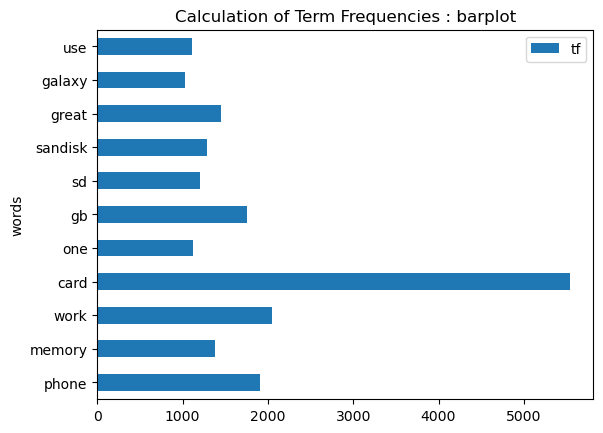

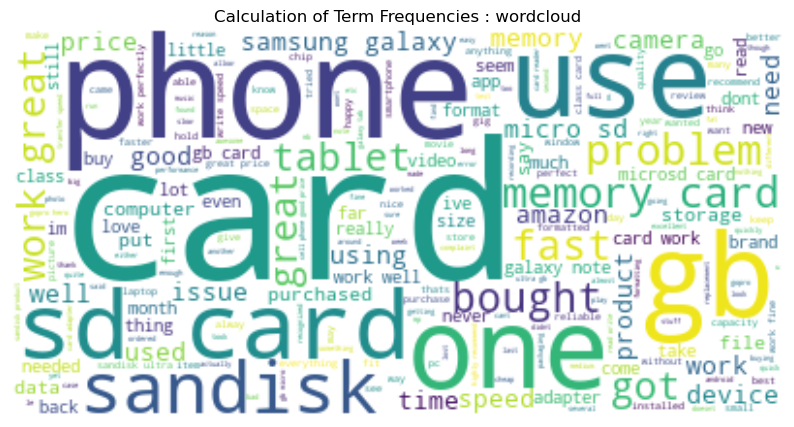

In [11]:
text_visulaization(df, "reviewText")

In [12]:
def create_polarity_scores(dataframe, dependent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

In [13]:
create_polarity_scores(df, "reviewText")


In [14]:
df.head()


,overall,reviewText,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,polarity_score
0,4,issue,0,0,0,0,0.0,0.0000
1,5,purchased device worked advertised never much ...,0,0,0,0,0.0,0.0000
2,4,work expected higher capacity think made bit e...,0,0,0,0,0.0,0.4019
3,5,think worked gb card went south one held prett...,0,0,0,0,0.0,0.6486
4,5,bought retail packaging arrived legit envelope...,0,0,0,0,0.0,0.8591


In [15]:
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [16]:
X, y = create_label(df, "reviewText", "sentiment_label")


In [17]:
# Split Dataset
train_x, test_x, train_y, test_y = train_test_split(X, y,  test_size=0.2, random_state=1)

In [18]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [19]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [20]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [21]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [22]:
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)
  return loj_model_count

In [23]:
loj_model_count = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.839


In [24]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [25]:
predict_count(train_x, model=loj_model_count, new_comment="The product had some issues would not reccommend it.")

Comment is Negative


In [26]:
predict_count(train_x, model=loj_model_count, new_comment="Hinge was problematic but the product itself is great and no regersts")

Comment is Positive


In [27]:
new_comment=pd.Series(df["reviewText"].sample(1).values)
print(new_comment)
predict_count(train_x, model=loj_model_count, new_comment = new_comment)

0    looking good memory card fast work flaw le sam...
dtype: object
Comment is Positive
